In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Starting block

In [ ]:
!pip install visualkeras

https://towardsdatascience.com/interpreting-image-classification-model-with-lime-1e7064a2f2e5

In [ ]:
!pip install lime

In [ ]:
'''Importing necessary libraries and modules'''

## Machine learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers

## Supporting libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import gc
from sys import getsizeof
import datetime
import visualkeras
from lime import lime_image
from skimage.segmentation import mark_boundaries

## Confusion Matrix and Classification report libraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## GradCam libraries
from keras.models import Model

# Dataset Preparation and optimisation

In [ ]:
gc.enable()

In [ ]:
'''Importing files from drive'''

headpath = "/content/drive/MyDrive/Final Year Project/dataset 2"

In [ ]:
train = np.load(os.path.join(headpath, "Train.npy"), allow_pickle=True)

In [ ]:
np.random.shuffle(train)

In [ ]:
train_features = [i[0] for i in train]
train_classes = [i[1] for i in train]
del(train)
gc.collect()

0

In [ ]:
test = np.load(os.path.join(headpath, "Test.npy"), allow_pickle=True)

In [ ]:
np.random.shuffle(test)

In [ ]:
test_features = [i[0] for i in test]
test_classes = [i[1] for i in test]
del(test)
gc.collect()

0

In [ ]:
validation = np.load(os.path.join(headpath, "Val.npy"), allow_pickle=True)

In [ ]:
np.random.shuffle(validation)

In [ ]:
validation_features = [i[0] for i in validation]
validation_classes = [i[1] for i in validation]
del(validation)
gc.collect()

0

In [ ]:
# valt = np.array(validation_classes)
# valt.flatten()
# for i in range(3):
#   print(np.count_nonzero(valt == i))

In [ ]:
label_list = ['fight', 'gun', 'knife']

In [ ]:
X = np.array([np.array(val) for val in train_features])
Y = np.array(train_classes)
del(train_features,train_classes)

In [ ]:
A = np.array([np.array(val) for val in validation_features])
B = np.array(validation_classes)
del(validation_features,validation_classes)

In [ ]:
E = np.array([np.array(val) for val in test_features])
F = np.array(test_classes)
del(test_features,test_classes)
gc.collect()

0

# Models

In [ ]:
# Analytical Functions

class ModelAnalysis():
  global label_list
  def __init__(self,model,dataset,history):
    self.model = model
    self.train = dataset[0]
    self.validation = dataset[1]
    self.test = dataset[2]
    self.trainingCallback = history

  def postAnalysis(self):
    def plotAccuracy():
      plt.plot(self.trainingCallback.history['accuracy'])
      plt.plot(self.trainingCallback.history['val_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epochs')
      plt.yticks(np.arange(0,1.1,0.1))
      plt.legend(['Training', 'Validation'])
      plt.show()

    def plotLoss():
      plt.plot(self.trainingCallback.history['loss'])
      plt.plot(self.trainingCallback.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epochs')
      plt.legend(['Training', 'Validation'])
      plt.show()

    def testing():
      result = self.model.evaluate(self.test[0],self.test[1], batch_size=32,verbose=0)
      print(f'\nTesting: \nLoss = {result[0]} \nAccuracy = {result[1]*100:.4f}\n')
    
    def confusionMatrix():
      predictions = self.model.predict(self.test[0],verbose=0)
      predictions = np.argmax(predictions, axis=1)

      figsize = (12,12)
      ConfusionMatrixDisplay.from_predictions(self.test[1],predictions,cmap='Blues',display_labels=label_list, normalize='true', ax=plt.subplots(figsize=figsize)[1])
      print(classification_report(self.test[1], predictions))
    
    plotAccuracy()
    plotLoss()
    testing()
    confusionMatrix()

  def GradCamAnalysis(self,layers,eps=0.5,rnd=None):
    def GradCam(model, img_array, layer_name, eps=1e-8):
      '''
      Creates a grad-cam heatmap given a model and a layer name contained with that model
      

      Args:
        model: tf model
        img_array: (img_width x img_width) numpy array
        layer_name: str


      Returns 
        uint8 numpy array with shape (img_height, img_width)

      '''

      gradModel = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output,
          model.output])
      
      with tf.GradientTape() as tape:
        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
      # use automatic differentiation to compute the gradients
      grads = tape.gradient(loss, convOutputs)
      
      # compute the guided gradients
      castConvOutputs = tf.cast(convOutputs > 0, "float32")
      castGrads = tf.cast(grads > 0, "float32")
      guidedGrads = castConvOutputs * castGrads * grads
      # the convolution and guided gradients have a batch dimension
      # (which we don't need) so let's grab the volume itself and
      # discard the batch
      convOutputs = convOutputs[0]
      guidedGrads = guidedGrads[0]
      # compute the average of the gradient values, and using them
      # as weights, compute the ponderation of the filters with
      # respect to the weights
      weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
      cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    
      # grab the spatial dimensions of the input image and resize
      # the output class activation map to match the input image
      # dimensions
      (w, h) = (img_array.shape[2], img_array.shape[1])
      heatmap = cv2.resize(cam.numpy(), (w, h))
      # normalize the heatmap such that all values lie in the range
      # [0, 1], scale the resulting values to the range [0, 255],
      # and then convert to an unsigned 8-bit integer
      numer = heatmap - np.min(heatmap)
      denom = (heatmap.max() - heatmap.min()) + eps
      heatmap = numer / denom
      # heatmap = (heatmap * 255).astype("uint8")
      # return the resulting heatmap to the calling function
      return heatmap

    def sigmoid(x, a, b, c):
      return c / (1 + np.exp(-a * (x-b)))

    def superimpose(img_bgr, cam, thresh, emphasize=False):
      
      '''
      Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
      

      Args:
        image: (img_width x img_height x 3) numpy array
        grad-cam heatmap: (img_width x img_width) numpy array
        threshold: float
        emphasize: boolean

      Returns 
        uint8 numpy array with shape (img_height, img_width, 3)

      '''
      heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
      if emphasize:
          heatmap = sigmoid(heatmap, 50, thresh, 1)
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
      
      hif = .8
      superimposed_img = heatmap * hif + img_bgr
      superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
      superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
      
      return superimposed_img_rgb

    #activation_layers = ['vgg.block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
    activation_layers = layers
    rnd = rnd if rnd != None else random.randint(0,int(E.shape[0]))
    print(rnd)
    img = self.test[0][rnd]
    plt.figure(figsize=(15, 15))
    for i, layer in enumerate(activation_layers):
      grad_cam = GradCam(self.model, np.expand_dims(img, axis=0), layer)
      ax = plt.subplot(7, 5, i +1)
      plt.imshow(grad_cam)
      plt.title(layer)
      plt.axis("off")
    plt.tight_layout()

    plt.figure(figsize=(15, 15))
    for i, layer in enumerate(activation_layers):
      grad_cam = GradCam(self.model, np.expand_dims(img, axis=0), layer)
      grad_cam_emphasized = superimpose(cv2.cvtColor(img,cv2.COLOR_BGR2RGB), grad_cam, eps, emphasize=True)
      ax = plt.subplot(7, 5, i +1)
      plt.imshow(grad_cam_emphasized)
      plt.title(layer)
      plt.axis("off")
    plt.tight_layout()

  def saveModel(self,architecture):
    self.architecture = architecture
    timing = datetime.datetime.now()
    fname = f"Identification-model-currency-{self.architecture}-{timing.strftime('%d-%b-%Y-%I-%M')}.h5"
    self.model.save(os.path.join(headpath,'Model',fname))
  
  def visualiseModel(self,compact=False):
    if compact:
      return visualkeras.layered_view(self.model, legend=True,max_z=150)
    else:
      return visualkeras.layered_view(self.model, legend=True)

  def LimeAnalysis(self,model,rnd = None,samples=100):
    rnd = rnd if rnd != None else random.randint(0,int(E.shape[0]))
    print(rnd)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(self.test[0][rnd], self.model.predict,top_labels=3, hide_color=0, num_samples=samples)
    
    temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    ax1.imshow(mark_boundaries(temp_1, mask_1))
    ax2.imshow(mark_boundaries(temp_2, mask_2))
    ax1.axis('off')
    ax2.axis('off')

## Simple CNN

In [ ]:
cnn_model = keras.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3),(2,2), activation='relu', input_shape=(200, 300,3),padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu',padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(256, (3, 3), activation='relu',padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(512, (3, 3), activation='relu',padding="same"))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.GlobalAveragePooling2D())
# cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(1500, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(750, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(350, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(180, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(90, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(45, activation='relu'))
cnn_model.add(layers.Dropout(0.4))
cnn_model.add(layers.Dense(3, activation='softmax'))

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 100, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 50, 75, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:
cnn_model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer= tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])

In [ ]:
fit_model = cnn_model.fit(X,Y,batch_size=32,validation_data=(A,B),epochs=50,shuffle=True)

Epoch 1/50
258/258 [==============================] - 32s 35ms/step - loss: 1.3348 - accuracy: 0.3841 - val_loss: 1.0083 - val_accuracy: 0.7390
Epoch 2/50
258/258 [==============================] - 8s 31ms/step - loss: 1.0638 - accuracy: 0.4688 - val_loss: 0.8436 - val_accuracy: 0.7252
Epoch 3/50
258/258 [==============================] - 8s 32ms/step - loss: 0.9408 - accuracy: 0.5456 - val_loss: 0.7095 - val_accuracy: 0.7408
Epoch 4/50
258/258 [==============================] - 8s 31ms/step - loss: 0.8494 - accuracy: 0.6156 - val_loss: 0.6046 - val_accuracy: 0.7941
Epoch 5/50
258/258 [==============================] - 8s 32ms/step - loss: 0.7658 - accuracy: 0.6657 - val_loss: 0.5498 - val_accuracy: 0.8097
Epoch 6/50
258/258 [==============================] - 9s 33ms/step - loss: 0.6858 - accuracy: 0.7069 - val_loss: 0.5142 - val_accuracy: 0.8199
Epoch 7/50
258/258 [==============================] - 8s 31ms/step - loss: 0.6313 - accuracy: 0.7336 - val_loss: 0.4717 - val_accuracy: 0.841

In [ ]:
CNN = ModelAnalysis(cnn_model,[(X,Y),(A,B),(E,F)],fit_model)

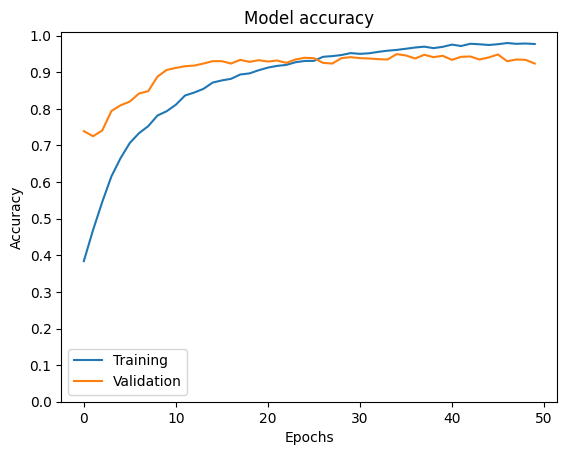

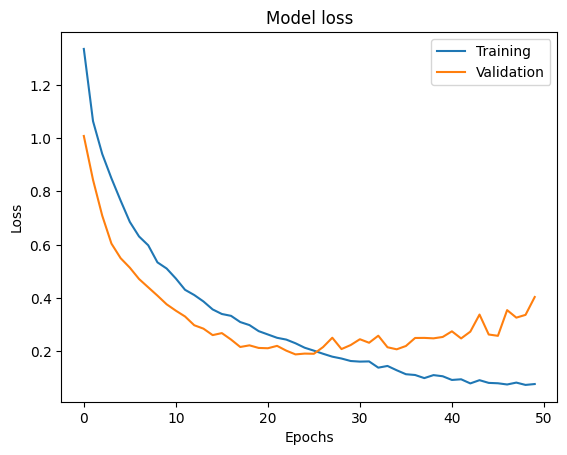


Testing: 
Loss = 0.16758321225643158 
Accuracy = 95.3942

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       433
           1       0.87      0.98      0.92       296
           2       0.99      0.99      0.99       400

    accuracy                           0.95      1129
   macro avg       0.95      0.96      0.95      1129
weighted avg       0.96      0.95      0.95      1129



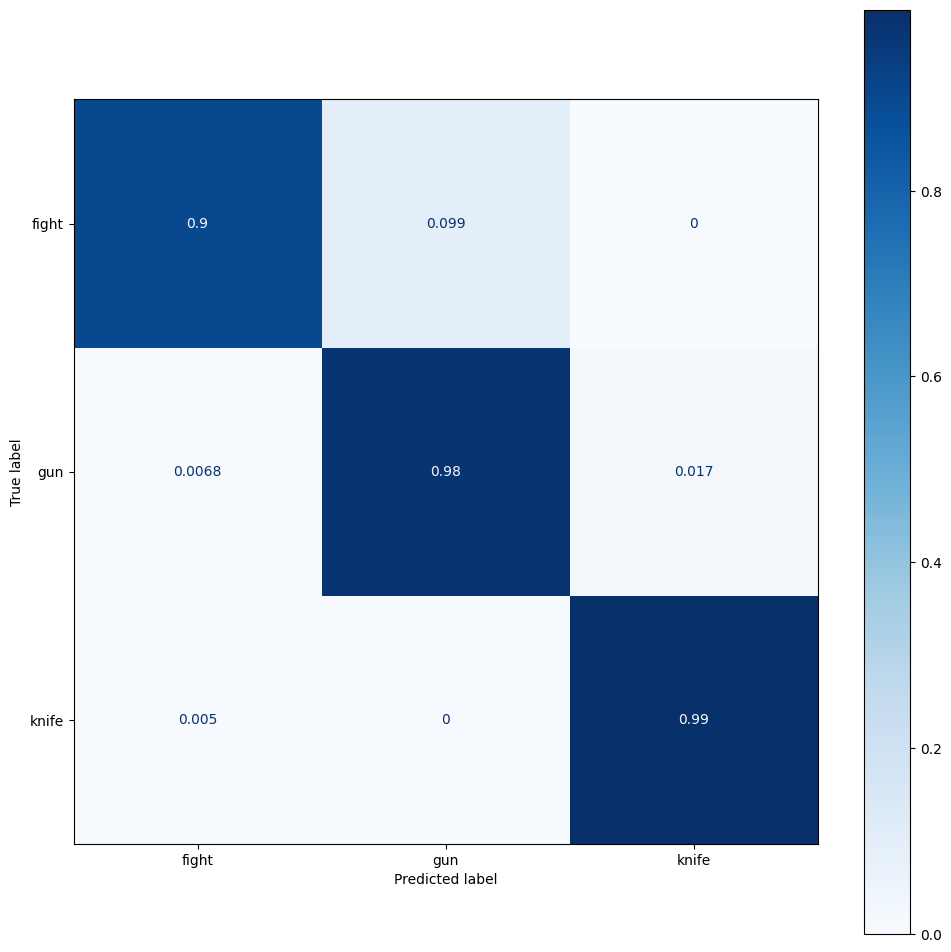

In [ ]:
CNN.postAnalysis()

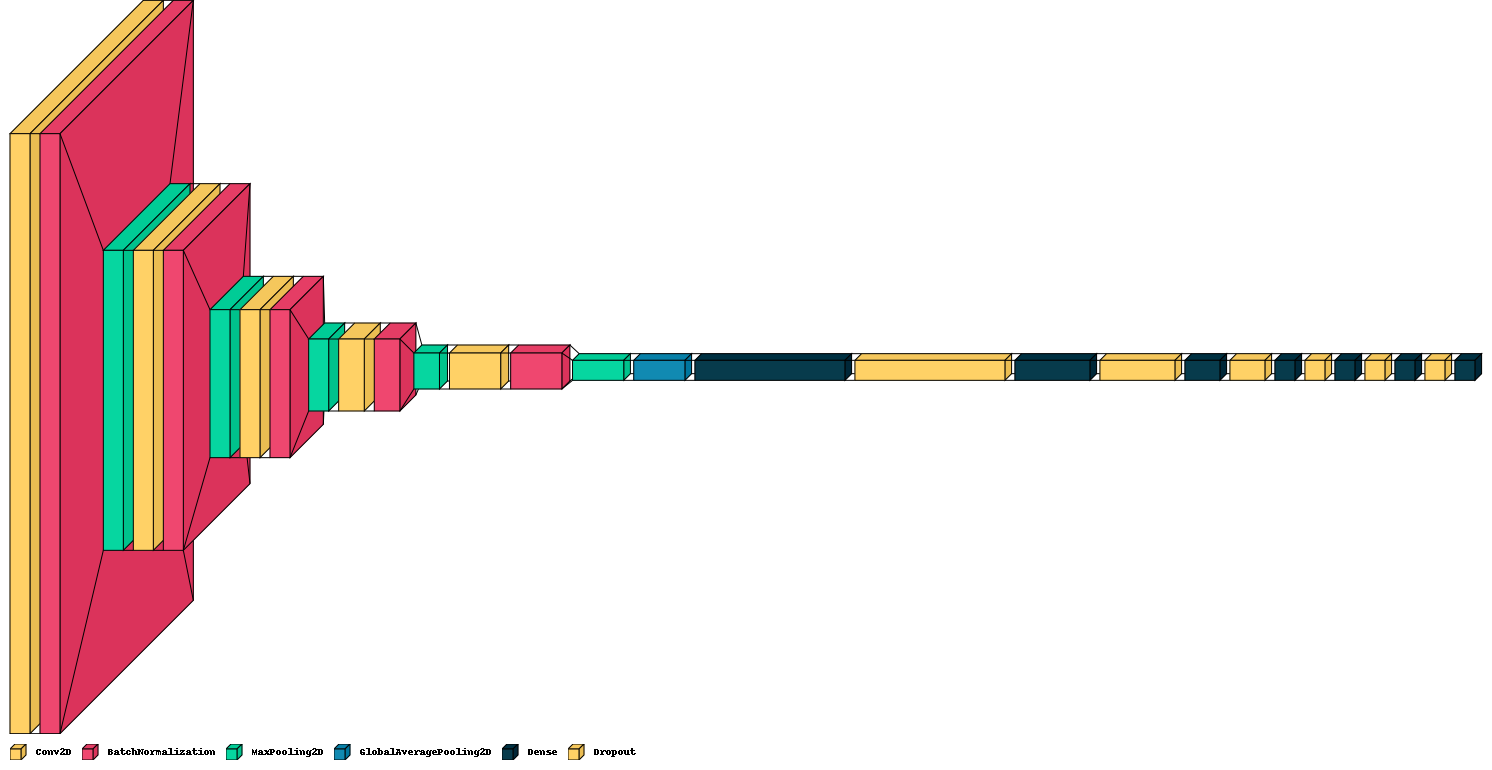

In [ ]:
CNN.visualiseModel(compact=True)

In [ ]:
CNN.saveModel('CNN')

## ResNet50V2

In [ ]:
resnetv2base = tf.keras.applications.ResNet50V2(input_shape=(200,300,3),weights='imagenet',include_top=False)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
resnetv2base.trainable = False

In [ ]:
resnetv2base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [ ]:
last_layer = resnetv2base.output

downlayers = tf.keras.layers.Flatten()(last_layer)
downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
downlayers = tf.keras.layers.Dense(3,activation='softmax')(downlayers)

resnetv2 = Model(inputs=resnetv2base.input, outputs=downlayers)

resnetv2.compile(optimizer= tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])

In [ ]:
resnetv2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 306, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history = resnetv2.fit(X,Y,batch_size=32,validation_data=(A,B),epochs=40,shuffle=True)

Epoch 1/40
258/258 [==============================] - 47s 129ms/step - loss: 46.0442 - accuracy: 0.5959 - val_loss: 8.7485 - val_accuracy: 0.8603
Epoch 2/40
258/258 [==============================] - 30s 116ms/step - loss: 29.8296 - accuracy: 0.7224 - val_loss: 4.6741 - val_accuracy: 0.8989
Epoch 3/40
258/258 [==============================] - 30s 116ms/step - loss: 25.7022 - accuracy: 0.7536 - val_loss: 4.8965 - val_accuracy: 0.9090
Epoch 4/40
258/258 [==============================] - 30s 117ms/step - loss: 23.6473 - accuracy: 0.7794 - val_loss: 5.3569 - val_accuracy: 0.9292
Epoch 5/40
258/258 [==============================] - 30s 118ms/step - loss: 20.9888 - accuracy: 0.7901 - val_loss: 6.4555 - val_accuracy: 0.9044
Epoch 6/40
258/258 [==============================] - 30s 118ms/step - loss: 19.2486 - accuracy: 0.8089 - val_loss: 4.2431 - val_accuracy: 0.9458
Epoch 7/40
258/258 [==============================] - 32s 125ms/step - loss: 16.7619 - accuracy: 0.8234 - val_loss: 4.0366 -

In [ ]:
RESNET50V2 = ModelAnalysis(resnetv2,[(X,Y),(A,B),(E,F)],history)

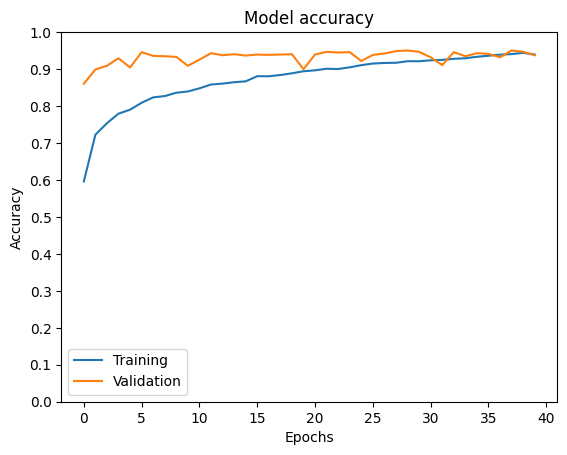

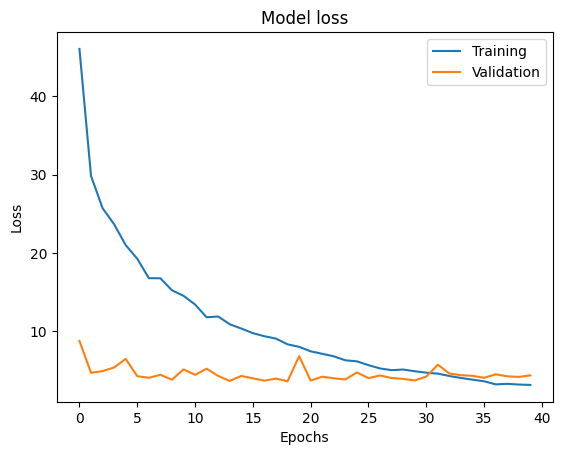


Testing: 
Loss = 4.424891471862793 
Accuracy = 93.1798

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       433
           1       0.82      0.98      0.89       296
           2       0.98      0.99      0.99       400

    accuracy                           0.93      1129
   macro avg       0.93      0.94      0.93      1129
weighted avg       0.94      0.93      0.93      1129



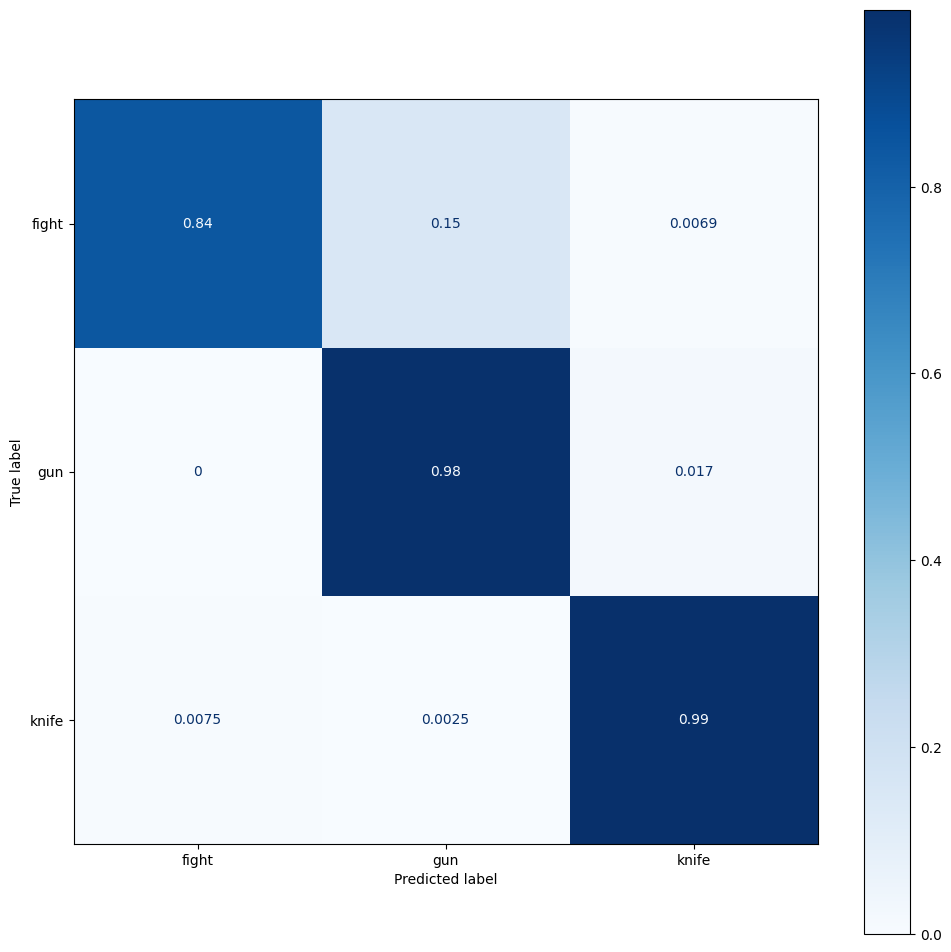

In [ ]:
RESNET50V2.postAnalysis()

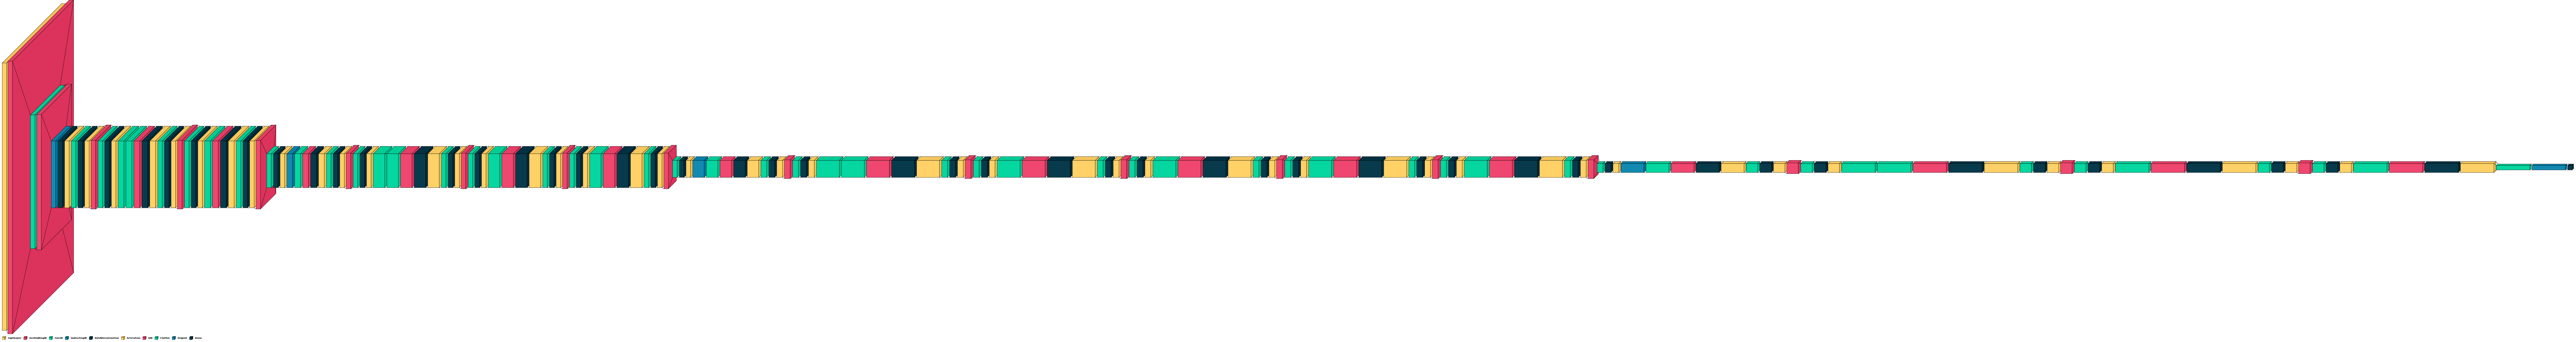

In [ ]:
RESNET50V2.visualiseModel(compact=True)

## VGG19

In [ ]:
vgg19base = tf.keras.applications.VGG19(input_shape=(200,300,3),weights='imagenet',include_top=False)
vgg19base.trainable = False 

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
vgg19base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 75, 128)       0     

In [ ]:
last_layer = vgg19base.output

downlayers = tf.keras.layers.Flatten()(last_layer)

downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
downlayers = tf.keras.layers.Dense(512,activation='relu')(downlayers)

# downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
# downlayers = tf.keras.layers.Dense(128,activation='relu')(downlayers)

# downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
# downlayers = tf.keras.layers.Dense(32,activation='relu')(downlayers)

downlayers = tf.keras.layers.Dropout(0.4)(downlayers)
downlayers = tf.keras.layers.Dense(3,activation='softmax')(downlayers)

vgg19 = Model(inputs=vgg19base.input, outputs=downlayers)

vgg19.compile(optimizer= tf.keras.optimizers.Adam(1e-5),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'])

In [ ]:
vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 75, 128)       0     

In [ ]:
vgg19fit = vgg19.fit(X,Y,batch_size=32,validation_data=(A,B),epochs=35,shuffle=True)

Epoch 1/35
258/258 [==============================] - 71s 219ms/step - loss: 6.6244 - accuracy: 0.5736 - val_loss: 0.6304 - val_accuracy: 0.8888
Epoch 2/35
258/258 [==============================] - 54s 210ms/step - loss: 2.5910 - accuracy: 0.7578 - val_loss: 0.4389 - val_accuracy: 0.9246
Epoch 3/35
258/258 [==============================] - 60s 233ms/step - loss: 1.7442 - accuracy: 0.8124 - val_loss: 0.3528 - val_accuracy: 0.9412
Epoch 4/35
258/258 [==============================] - 58s 223ms/step - loss: 1.3169 - accuracy: 0.8511 - val_loss: 0.3198 - val_accuracy: 0.9476
Epoch 5/35
258/258 [==============================] - 58s 224ms/step - loss: 1.0160 - accuracy: 0.8725 - val_loss: 0.3033 - val_accuracy: 0.9467
Epoch 6/35
258/258 [==============================] - 62s 241ms/step - loss: 0.8830 - accuracy: 0.8873 - val_loss: 0.3117 - val_accuracy: 0.9449
Epoch 7/35
258/258 [==============================] - 59s 227ms/step - loss: 0.7110 - accuracy: 0.8951 - val_loss: 0.2947 - val_ac

In [ ]:
VGG19 = ModelAnalysis(vgg19,[(X,Y),(A,B),(E,F)],vgg19fit)

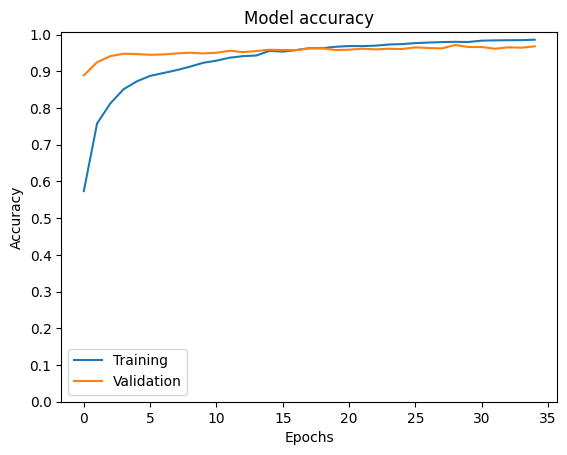

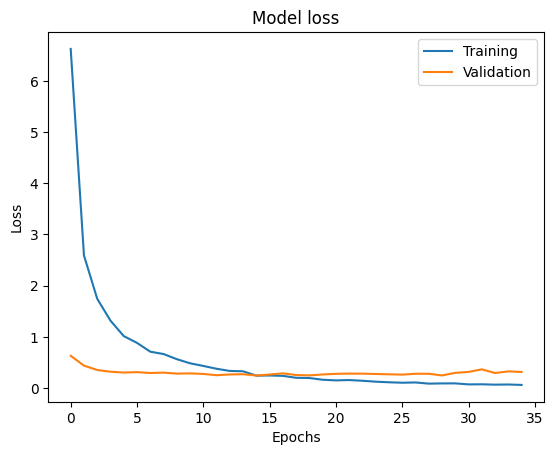


Testing: 
Loss = 0.36542215943336487 
Accuracy = 96.5456

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       433
           1       0.89      1.00      0.94       296
           2       1.00      0.99      1.00       400

    accuracy                           0.97      1129
   macro avg       0.96      0.97      0.96      1129
weighted avg       0.97      0.97      0.97      1129



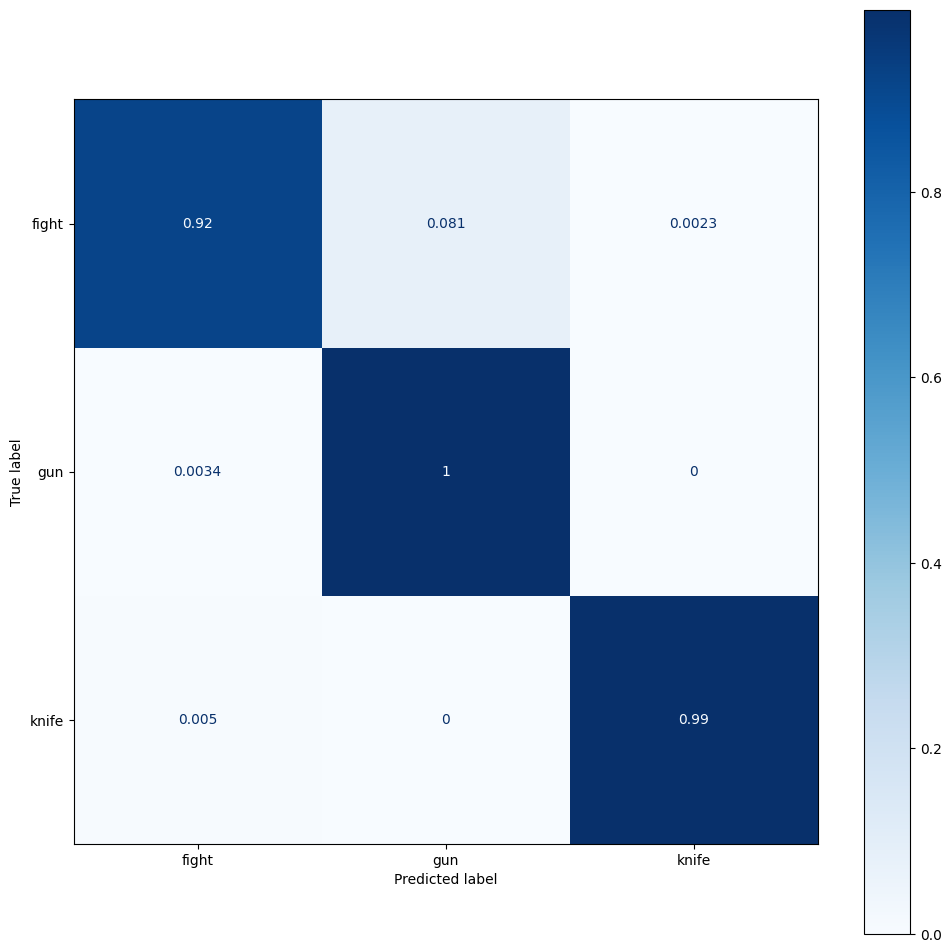

In [ ]:
VGG19.postAnalysis()

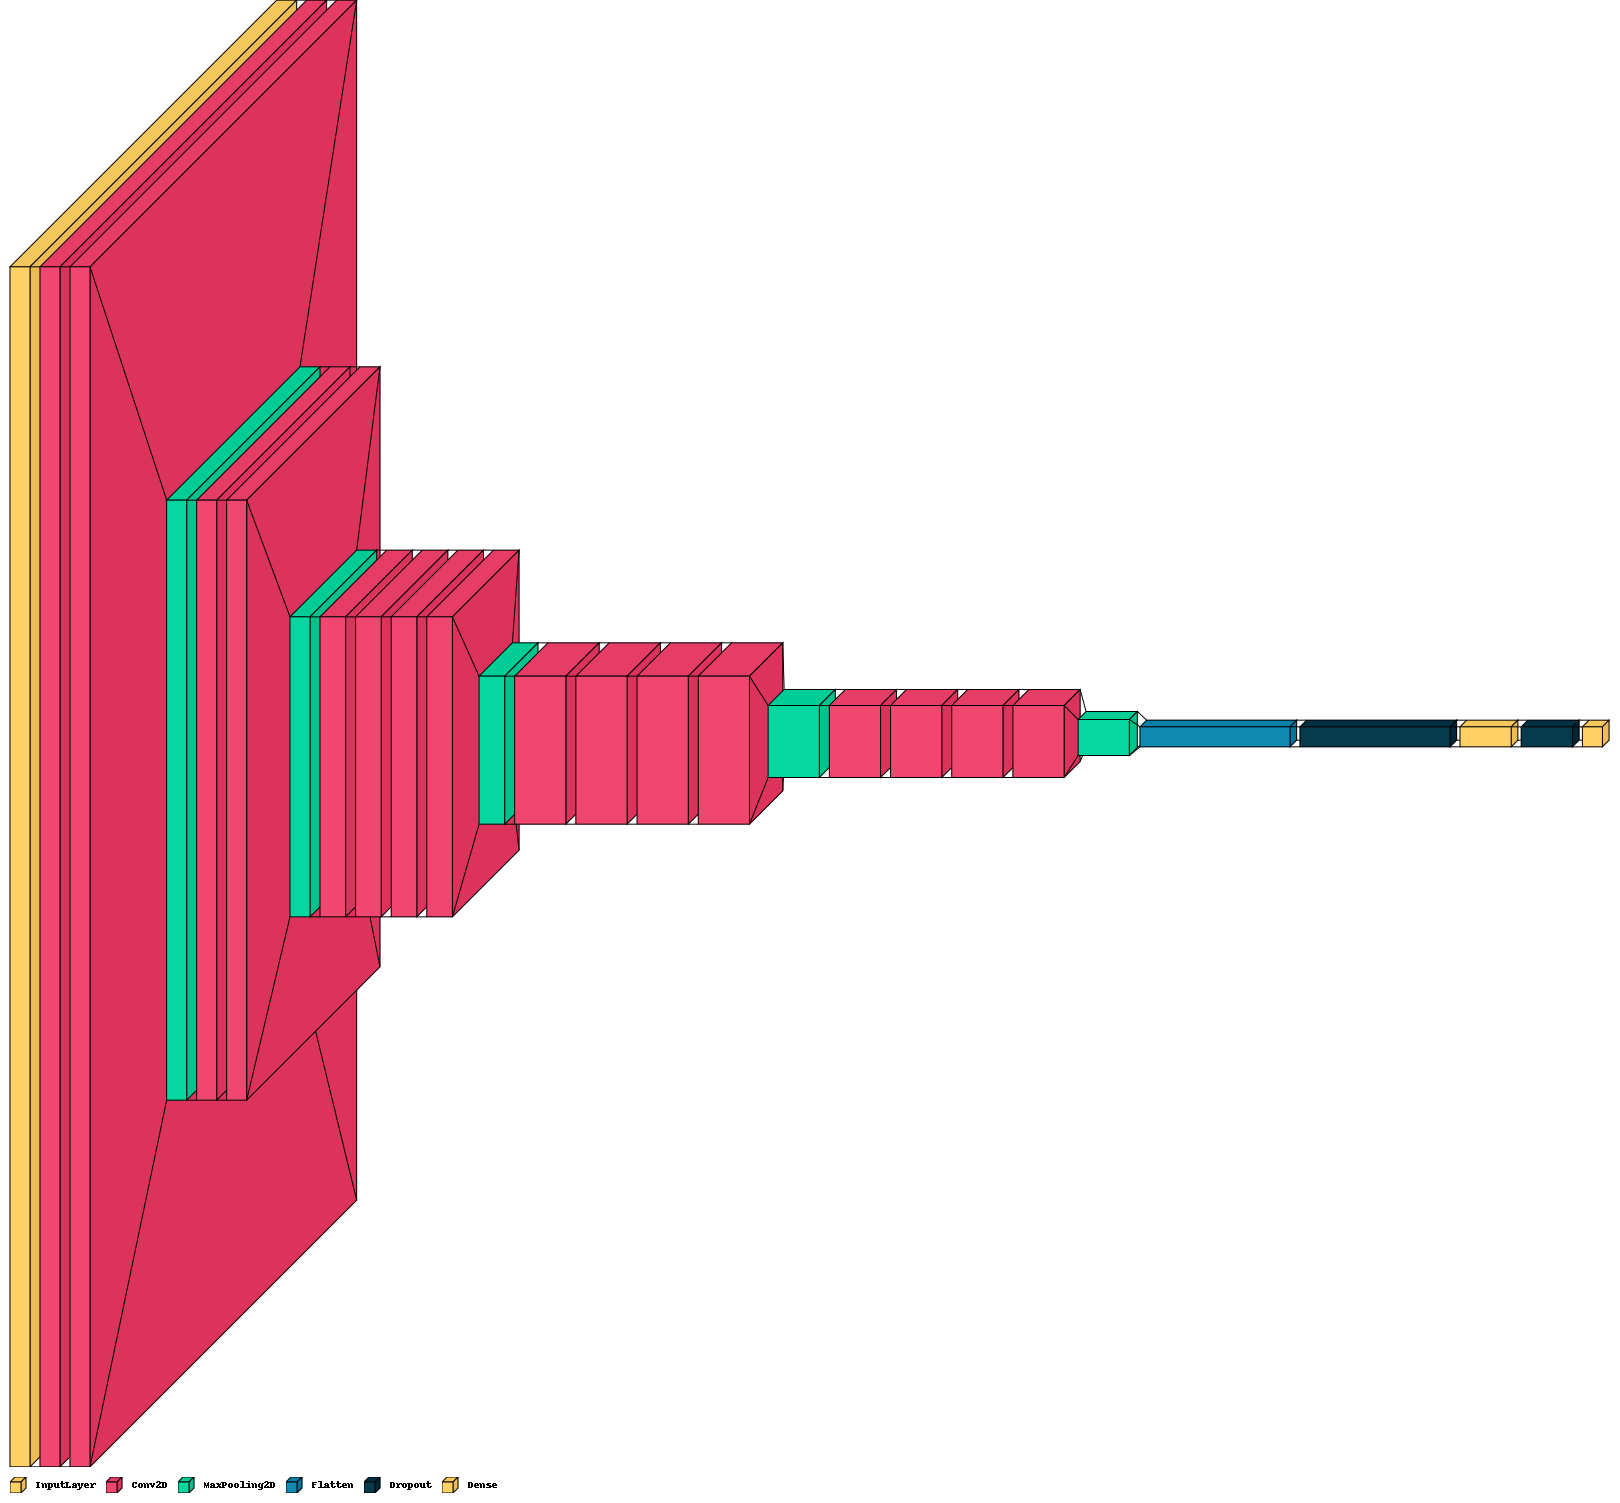

In [ ]:
VGG19.visualiseModel(compact=True)

In [ ]:
vgg19.save('vgg19.h5')

# Rest of testing 

## Image Testing

In [ ]:
# Testing Single Image

test_img = cv2.imread("validation_1.png")
test_img = np.squeeze(test_img)
test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
test_img = cv2.resize(test_img,(300,200))
show_img = test_img.copy()
# test_img =  E[400]
# show_img = test_img
test_img = np.array([np.array(test_img)])

y_out = vgg19.predict(test_img)
y_out = y_out*100
# print(y_out)
index = np.argmax(y_out)
plt.imshow(show_img)
label = f"{label_list[np.argmax(y_out)]} : {y_out[0][index]:.2f}%"
plt.title(label)

In [ ]:
# Testing Multiple Images

images = os.listdir()
for i in [".config","drive",'.ipynb_checkpoints','sample_data']:
  try:
    images.remove(i)
  except Exception:
    pass

#images = [ E[random.randint(0,int(E.shape[0]))] for i in range(10)]
for i in images:
  # print(i)
  test_img = cv2.imread(i)
  #test_img = i
  try:
    if test_img.shape[0] > test_img.shape[1]:
      test_img = cv2.rotate(test_img, cv2.ROTATE_90_CLOCKWISE)
    test_img = np.squeeze(test_img)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(300,200))
    show_img = test_img.copy()
    test_img = np.array([np.array(test_img)])

    y_out = vgg19.predict(test_img)
    plt.figure()
    plt.imshow(show_img)
    y_out = y_out*100
    index = np.argmax(y_out)
    label = f"{label_list[np.argmax(y_out)]} : {y_out[0][index]:.2f}%"
    

    plt.title(label)
    plt.show()
  except Exception:
    print(f"Error happend for image {i}")
    continue